In [1]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


In [3]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [6]:
data[data['frequency'] > 0]['frequency'].plot(kind='hist', bins=20) #subplot 1
data[data['recency'] > 0]['recency'].plot(kind='hist', bins=20) #subplot 2
print (data[data['frequency'] > 0]['frequency'].describe()) 
print (data[data['recency'] > 0]['recency'].describe()) 

count    946.000000
mean       2.597252
std        2.813338
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       29.000000
Name: frequency, dtype: float64
count    946.000000
mean      17.056575
std       10.619316
min        0.140000
25%        7.325000
50%       17.785000
75%       26.000000
max       38.430000
Name: recency, dtype: float64


### Basic Frequency/Recency analysis using the BG/NBD model

In [7]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


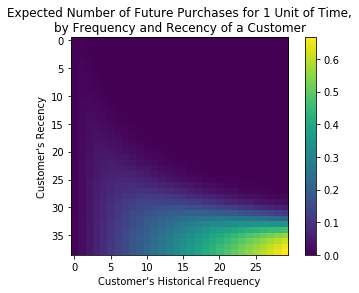

In [12]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
plot=plot_frequency_recency_matrix(bgf)
plt.show()

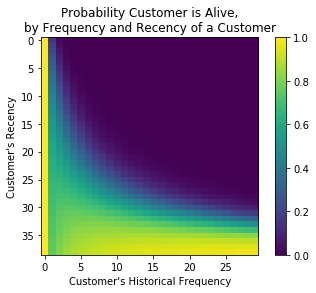

In [17]:
from lifetimes.plotting import plot_probability_alive_matrix
plot=plot_probability_alive_matrix(bgf)
plt.show()

### Assessing model fit

The first is to compare your data versus artificial data simulated with your fitted model’s parameters.

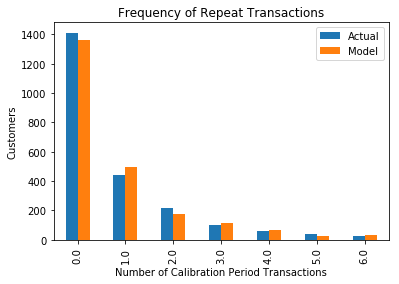

In [21]:
from lifetimes.plotting import plot_period_transactions
plot=plot_period_transactions(bgf)
plt.show()

In this first figure, we plot the expected number of customers that are going to repeat purchase 0, 1, 2, 3 ... 10 times in the future.

In [25]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0               121
1             0.0          0.0  103.0                0.0               121
2             6.0        142.0  171.0                0.0               121
3             0.0          0.0   26.0                0.0               121
4             2.0          9.0   62.0                0.0               121


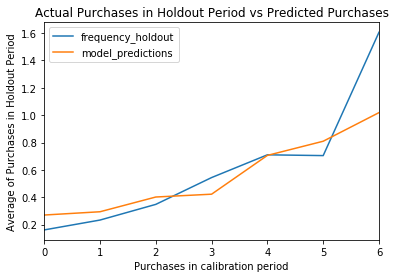

In [28]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot=plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show()

### Customer Predictions

Based on customer history, we can predict what an individuals future purchases might look like

In [30]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

### 预测一个单独的

In [31]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.057085219311699784

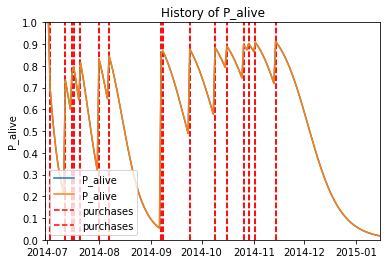

In [33]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot=plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.show()

#  estimate the CLV for our userbase 

### The Gamma-Gamma model and the independence assumption

In [35]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [36]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [37]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [38]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658623
2     18.911498
3     35.171004
4     35.171004
5     35.171004
6     71.462843
7     18.911498
8     35.171004
9     27.282413
10    35.171004
dtype: float64


In [40]:
LTV=ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    )

In [41]:
LTV

customer_id
1        24.658623
2        18.911498
3        35.171004
4        35.171004
5        35.171004
6        71.462843
7        18.911498
8        35.171004
9        27.282413
10       35.171004
11       29.902782
12       35.171004
13       35.171004
14       35.171004
15       35.171004
16       35.171004
17       24.699911
18       17.674716
19       26.368713
20       35.171004
21       32.816969
22       35.171004
23       35.171004
24       35.171004
25       35.171004
26      168.555072
27       35.171004
28       66.638744
29       35.171004
30       38.852857
           ...    
2328     35.031342
2329     35.171004
2330     21.405905
2331     35.171004
2332    137.932980
2333     58.419013
2334     35.171004
2335     33.600011
2336     24.248656
2337     35.171004
2338     35.171004
2339     25.324694
2340     42.246214
2341     35.171004
2342     47.343568
2343     35.171004
2344     18.828890
2345     35.171004
2346     18.911498
2347     33.095747
2348     17.470623
